# NEO Orbit Visualization Study

First download NEO orbital data from JPL Horizons

Then figure out how to make a 3D plot
> with a dark background with NEO orbits and where the orbits are at time t (possibly add an interactive slider?)

> plot must be able to zoom in & out (again, interactive)


need to consult others for data format before we can integrate visualization tool into main branch

make an NEO class

In [3]:
# ? whether I should be concerned about JPL data only or the format that sorcha accepts

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
filename = 'sbdb_query_results(1).csv'
data = pd.read_csv(filename)

In [99]:
testObj = data.iloc[5] # 226 for Itokawa, 3 for Ganymed, 5 for Icarus

In [100]:
print(testObj)

spkid                       20001566
full_name      1566 Icarus (1949 MA)
pdes                            1566
H                              16.59
orbit_id                     JPL 159
epoch                      2460200.5
epoch_mjd                      60200
e                             0.8269
a                              1.078
q                              0.187
i                               22.8
om                             87.95
w                              31.44
ma                            168.65
n                             0.8805
Name: 5, dtype: object


In [11]:
data[data['e'] >= 1] # no para or hyperbolic orbits!

,spkid,full_name,pdes,H,orbit_id,epoch,epoch_mjd,e,a,q,i,om,w,ma,n


In [5]:
print(type(testObj.ma))

<class 'numpy.float64'>


In [ ]:
# convert to position vectors with given orbital elements a,e,i,om,w,M0,n,t0.
# we need position componenets x,y,z and true anomaly nu to visualize the orbit

In [88]:
# find mean anomaly using M0, n, t0 
def M02M(M0, n, t0, t): # n in deg/d
    return M0 + n*(t-t0) # t in days
# find eccentric anomaly from M using root finding method (Newton-Rhapson)
def M2E(M, e, k=1000, errLim=0.000000001):
    E = M # initial value M
    err = 1;
    for i in range(k):
        temp = E
        E = E - ((E-e*np.sin(E)-M)/(1-e*np.cos(E)))
        err = abs(temp - E)
        if np.all(err < errLim): # doesnt seem to need many iterations
            break
    return E
def M2E_2(M, e, k=100):
    # fixed point method
    E = M
    for i in range(k):
        E = M + e*np.sin(E)
    return E
# True anomaly from eccentric anomaly
def E2Nu(E, e):
    nu = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2)) # they dropped arctan 2.0 ??
    return nu

In [89]:
# radius from true anomaly (as a function of nu)
def nu2r(nu, e, a):
    return a*((1-e**2)/(1+e*np.cos(nu)))
# pos vector in PQW coord (Perifocal)
def elems2pqw(nu, r):
    x = r*np.cos(nu)
    y = r*np.sin(nu)
    # z = 0
    return x,y #,z
# pos vector in heliocentric cartesian (?) coord
def pqw2ijk(x,y,inc,om,w):
    # implement calculations - change of basis
    X= x*(np.cos(om)*np.cos(w)-np.sin(om)*np.cos(inc)*np.sin(w)) - y*(np.cos(om)*np.sin(w)+np.sin(om)*np.cos(inc)*np.cos(w))
    Y= x*(np.sin(om)*np.cos(w)+np.cos(om)*np.cos(inc)*np.sin(w)) - y*(np.sin(om)*np.sin(w)-np.cos(om)*np.cos(inc)*np.cos(w))
    Z= x*(np.sin(inc)*np.sin(w)) + y*(np.sin(inc)*np.cos(w))
    return X,Y,Z

In [90]:
# ijk pos with nu and r
def nur2ijk(nu, r, inc, om, w):
    X = r*(np.cos(om)*np.cos(nu+w)-np.sin(om)*np.sin(nu+w)*np.cos(inc))
    Y = r*(np.sin(om)*np.cos(nu+w)+np.cos(om)*np.sin(nu+w)*np.cos(inc))
    Z = r*(np.sin(inc)*np.sin(nu+w))
    return X,Y,Z

In [7]:
from astropy.time import Time, TimeDelta
from mpl_toolkits.mplot3d import axes3d
%matplotlib widget

In [9]:
test_t0 = Time(testObj.epoch, format='jd', scale='tdb')

In [10]:
print(test_t0) # OOOOOOO WOOOOOO THIS IS SO NICE!

2460200.5


In [11]:
time = Time.now().tdb.jd # get time at instance, convert to TDB and then JD
print(time)

2460367.6016821405


In [101]:
# plot pos in ijk as function of t
test_a = testObj.a
test_e = testObj.e
test_i = np.radians(testObj.i)
test_om = np.radians(testObj.om)
test_w = np.radians(testObj.w)
test_M0 = np.radians(testObj.ma)
test_n = np.radians(testObj.n)
test_time = Time(testObj.epoch, format='jd', scale='tdb')
test_t0 = test_time.jd # Time in TDB JD
# get time at instance, convert to TDB and then JD
td = Time.now()
today = td.tdb.jd

In [102]:
# Time series
today += 600
days_since_epoch = np.ceil(today - test_t0) # step size for linspace, rounded up
time = np.linspace(test_t0, today, int(days_since_epoch))
test_ma = M02M(test_M0, test_n, test_t0, time)
test_E = M2E(test_ma, test_e)

In [103]:
test_nu = E2Nu(test_E, test_e)
test_r = nu2r(test_nu, test_e, test_a)

In [104]:
test_x, test_y = elems2pqw(test_nu, test_r)
test_X, test_Y, test_Z = pqw2ijk(test_x, test_y, test_i, test_om, test_w)
# test_X, test_Y, test_Z = nur2ijk(test_nu, test_r, test_i, test_om, test_w)

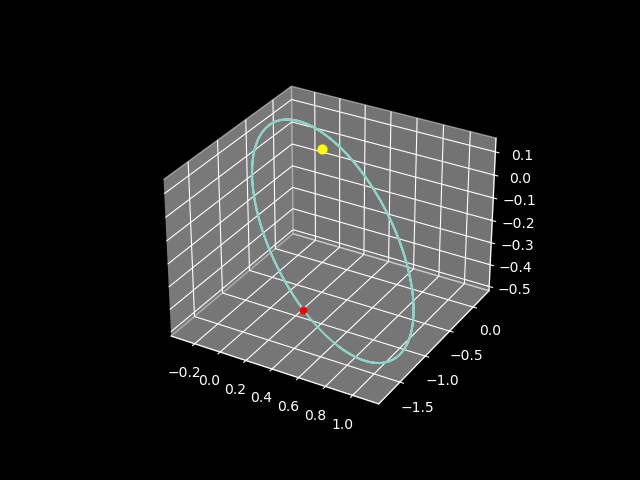

In [105]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_proj_type('persp')
ax.plot(test_X, test_Y, test_Z)
ax.scatter(0, 0, 0, c='yellow', s=40)
ax.scatter(test_X[-1], test_Y[-1], test_Z[-1], c='red', s=20)

Text(0.5, 0.92, '2024-02-28T05:34:37.388')

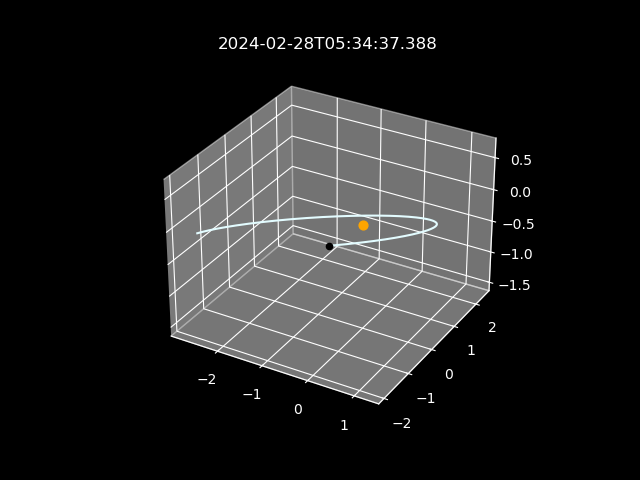

In [96]:
plt.style.use('dark_background')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot(test_X, test_Y, test_Z, color='#e3fcff', linestyle='-')
ax.scatter(0, 0, 0, c='orange', s=40)
ax.scatter(test_X[-1], test_Y[-1], test_Z[-1], c='black', s=20)
# ax.set_aspect('equal')  doesnt work
#ax.set_box_aspect([1,1,1])
ax.set_title(td.isot)

In [107]:
ecc = np.linspace(test_E[0], test_E[0] + 2*np.pi, 500) # full range of orbit, plot seperately from object pos
test_TA = E2Nu(ecc, test_e)
test_l = nu2r(test_TA, test_e, test_a)
test_xx, test_yy = elems2pqw(test_TA, test_l)
#posx, posy, posz = pqw2ijk(test_xx, test_yy, test_i, test_om, test_w)
test_zz = np.zeros(np.shape(test_xx))
posx, posy, posz = nur2ijk(test_TA, test_l, test_i, test_om, test_w)

Text(0.5, 0.92, 'obj:   1566 Icarus (1949 MA) \ndate: 2024-02-28T05:46:46.543')

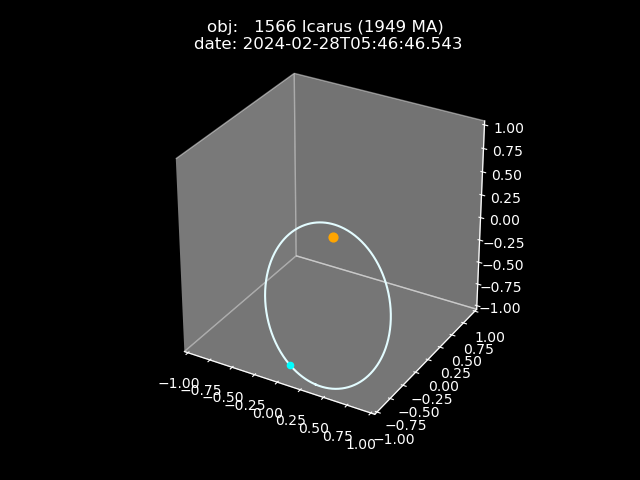

In [109]:
plt.close('all')
plt.style.use('dark_background')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot(posx, posy, posz, color='#e3fcff', linestyle='-')
ax.scatter(0, 0, 0, c='orange', s=40)
ax.scatter(test_X[-1], test_Y[-1], test_Z[-1], c='cyan', s=20)
#ax.plot(test_xx, test_yy, test_zz, color='#e3fcff', linestyle='-')

# ax.set_aspect('equal')  doesnt work
ax.set_box_aspect(aspect=(1, 1, 1))
# fix unwanted stretching
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
#ax.set_axis_off()
ax.grid(visible=False)
ax.set_title("obj: %s \ndate: %s" % (testObj.full_name, td.isot))